# <center>Audio Emotion Recognition</center>
## <center>Part 5 - Data augmentation</center>
#### <center> 7th September 2019 </center> 
#####  <center> Eu Jin Lok </center> 

## Introduction 
Continuing where we left off in [Part 3](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model) where we built a simple baseline model, now we're going to take the next level up and build in some data augmentation methods. I did some reading and desk reseach and there's a few good articles around on this:

- [Edward Ma](https://medium.com/@makcedward/data-augmentation-for-audio-76912b01fdf6)
- [Qishen Ha](https://www.kaggle.com/haqishen/augmentation-methods-for-audio)
- [Reza Chu](https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3)

Thanks to the various authors above, I've incorporated their methods into this notebook here. We'll go ahead and test a few methods for the authors, then implement some using the same 1D CNN model we used before so we can compare apples with apples exactly how much the accuracy contribution came from the data augmentation methods. 

1. [Explore augmentation methods](#explore)
    - [Static noise](#static)
    - [Shift](#shift)
    - [Stretch](#stretch)
    - [Pitch](#pitch)
    - [Dynamic change](#dynamic)
    - [Speed and pitch](#speed)
2. [Data preparation and processing](#data)
3. [Modelling](#modelling)
4. [Model serialisation](#serialise)
5. [Model validation](#validation)
6. [Final thoughts](#final)

Most importantly, I want to thank the 4 authors for their excellent dataset, without it, writing this notebook could not have been possible. The original source of the dataset links are below:
- [TESS](https://tspace.library.utoronto.ca/handle/1807/24487)
- [CREMA-D](https://github.com/CheyneyComputerScience/CREMA-D)
- [SAVEE](http://kahlan.eps.surrey.ac.uk/savee/Database.html)
- [RAVDESS](https://zenodo.org/record/1188976#.XYP8CSgzaUk)
- [RAVDESS_Kaggle](https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio)

In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Other  
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import os
from tqdm import tqdm
import pickle
import IPython.display as ipd  # To play sound in the notebook

In [2]:
#########################
# Augmentation methods
#########################
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound. Note that this expands the dataset slightly
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=-0.5 ,high=7)  # default low = 1.5, high = 3
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

####################################
# the confusion matrix heat map plot
####################################
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<a id="data"></a>
## 2. Data preparation and processing
I'm going to use just 2 augmentation method which is the noise, and the speed & pitch method. Just for demo purposes. So now lets apply it across all our audio data. We'll use the same data processing steps we followed in [part 3](https://www.kaggle.com/ejlok1/audio-emotion-part-3-baseline-model), except we add in the augmentation process in the loop. We are going to use the noise and speed pitch augmentation method

Actually I have also added one extra enhancement to the code, which is a progress bar using the tqdm library. Given that we're adding a few extra processing steps, it would be worthwhile to know how long we've progressed...

In [3]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("Data_path.csv")
ref.head()

,labels,source,path
0,male_sad,SAVEE,savee/JK_sa01.wav
1,male_sad,SAVEE,savee/JK_sa15.wav
2,male_neutral,SAVEE,savee/DC_n13.wav
3,male_surprise,SAVEE,savee/DC_su09.wav
4,male_neutral,SAVEE,savee/DC_n07.wav


In [4]:
# Note this takes a couple of minutes (~16 mins) as we're iterating over 4 datasets, and with augmentation  
df = pd.DataFrame(columns=['feature'])
df_noise = pd.DataFrame(columns=['feature'])
df_speedpitch = pd.DataFrame(columns=['feature'])
cnt = 0

# loop feature extraction over the entire dataset
for i in tqdm(ref.path):
    
    # first load the audio 
    X, sample_rate = librosa.load(i
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100
                                  ,offset=0.5
                                 )

    # take mfcc and mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=np.array(sample_rate), 
                                        n_mfcc=13),
                    axis=0)
    
    df.loc[cnt] = [mfccs]   

    # random shifting (omit for now)
    # Stretch
    # pitch (omit for now)
    # dyn change
    
    # noise 
    aug = noise(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_noise.loc[cnt] = [aug]

    # speed pitch
    aug = speedNpitch(X)
    aug = np.mean(librosa.feature.mfcc(y=aug, 
                                    sr=np.array(sample_rate), 
                                    n_mfcc=13),    
                  axis=0)
    df_speedpitch.loc[cnt] = [aug]   

    cnt += 1

df.head()

100%|█████████████████████████████████████| 12162/12162 [06:45<00:00, 29.99it/s]


,feature
0,"[-8.812323, -12.111704, -22.594236, -21.481213..."
1,"[-8.846449, -13.126469, -24.391258, -23.972637..."
2,"[-2.0016844, -2.284187, -8.079335, -7.4936047,..."
3,"[-3.6122105, -4.3207064, -7.5397205, -8.864785..."
4,"[-0.89232916, -2.7065623, -9.859098, -8.692251..."


Right so ~13 mins for completion, so its definitely longer, almost double the amount of time with the 2 augmentation methods in the loop. Instead of the one data object that we get out, we now get 2 other ones, one for each of the 2 augmentation methods we've used. 

We'll need to stack them on top of each other to make a larger dataset. But before we do so, we need to make sure the number of columns for the 3 datasets are the same. So lets check it out before we stack them 

_NOTE: If using the stretch augmentation, the audio duration becomes artifically longer and thus the number of columns will be different from original. So some padding will need to be done to the original dataset_

In [5]:
# combine 
df = pd.concat([ref,pd.DataFrame(df['feature'].values.tolist())],axis=1)
df_noise = pd.concat([ref,pd.DataFrame(df_noise['feature'].values.tolist())],axis=1)
df_speedpitch = pd.concat([ref,pd.DataFrame(df_speedpitch['feature'].values.tolist())],axis=1)
print(df.shape,df_noise.shape,df_speedpitch.shape)

(12162, 219) (12162, 219) (12162, 219)


Great so the shape of all the 3 datasets are the same. Thats expected. So our new dataset once stacked on top, will be 3 times the original size, which is handy since Deep Learning needs alot of data

In [6]:
df = pd.concat([df,df_noise,df_speedpitch],axis=0,sort=False)
df=df.fillna(0)
del df_noise, df_speedpitch

df.head()

,labels,source,path,0,1,2,3,4,5,6,...,206,207,208,209,210,211,212,213,214,215
0,male_sad,SAVEE,savee/JK_sa01.wav,-8.812323,-12.111704,-22.594236,-21.481213,-20.949923,-20.414589,-20.267546,...,-8.499665,-10.080904,-12.700767,-17.040066,-20.240370,-23.302593,-24.621033,-23.829395,-14.862103,-9.119078
1,male_sad,SAVEE,savee/JK_sa15.wav,-8.846449,-13.126469,-24.391258,-23.972637,-23.494141,-24.208843,-25.631187,...,-8.738686,-8.822194,-8.977810,-9.998902,-15.777991,-22.670012,-23.585888,-24.138813,-17.324165,-9.067064
2,male_neutral,SAVEE,savee/DC_n13.wav,-2.001684,-2.284187,-8.079335,-7.493605,-7.611511,-5.591491,-4.388685,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,male_surprise,SAVEE,savee/DC_su09.wav,-3.612211,-4.320706,-7.539721,-8.864785,-8.661814,-8.826547,-9.143905,...,-25.902903,-25.006645,-24.709745,-25.516710,-26.941380,-25.354641,-25.213074,-27.607460,-16.149431,-8.528477
4,male_neutral,SAVEE,savee/DC_n07.wav,-0.892329,-2.706562,-9.859098,-8.692251,-8.685308,-8.844448,-8.032232,...,-11.438392,-11.691320,-11.480921,-10.730117,-9.891497,-9.329517,-8.907434,-8.881425,-8.354048,-5.121765


So now after stacking them, we'll go ahead and split the dataset as per the usual...

In [7]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
3857,-18.789873,-16.257823,-18.146255,-21.355185,-22.573781,-24.118982,-25.587561,-24.356530,-23.567643,-22.297543,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7298,-9.926879,-12.207489,-13.001415,-12.788457,-12.032904,-10.788927,-10.109611,-10.518634,-11.727543,-13.143132,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5874,-19.433008,-17.991457,-18.031151,-16.913448,-16.283546,-16.404930,-18.041887,-15.778324,-15.361289,-16.340349,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
858,-41.620898,-39.332067,-38.304632,-37.318280,-38.456459,-39.606808,-38.668954,-38.982931,-38.938741,-39.069179,...,-41.625049,-40.537943,-39.196040,-37.761340,-36.314312,-36.834616,-36.414346,-38.115994,-39.350067,-39.302048
891,-29.860798,-25.242838,-22.392869,-21.261831,-24.655071,-23.375435,-21.373668,-21.425951,-23.581289,-23.255515,...,-21.906756,-23.513019,-23.406727,-23.334602,-22.857874,-23.331766,-24.598323,-21.843664,-21.684176,-24.059751
1748,-58.345547,-55.412263,-54.743924,-50.039359,-49.420550,-53.196057,-52.166383,-53.193788,-55.860768,-56.179307,...,-55.952464,-55.788269,-56.903894,-57.412319,-58.057587,-56.945340,-57.241270,-54.970584,-52.925365,-55.895808
9995,-6.042688,-7.824290,-7.652110,-7.676593,-9.049875,-8.188551,-8.382911,-9.500729,-7.820496,-7.235802,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5771,-18.790920,-15.083409,-17.024273,-17.871830,-17.670866,-16.764324,-16.967266,-14.339260,-13.911373,-11.508418,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1029,-50.257412,-48.152718,-48.095741,-50.326332,-53.339642,-49.717400,-48.847088,-47.471321,-48.822487,-51.294987,...,-61.953701,-61.953701,-61.953701,-61.953701,-61.953701,-61.953701,-61.953701,-61.953701,-61.953701,-61.953701
10882,-16.416145,-14.907698,-12.271024,-11.320656,-10.501280,-11.062640,-9.891876,-10.069219,-12.853498,-15.195144,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


... and then we normalise our dataset

In [8]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
3857,0.213931,0.381605,0.386615,0.120883,0.016123,-0.112618,-0.235052,-0.140175,-0.081220,0.015777,...,0.533991,0.521554,0.521557,0.522242,0.508766,0.508889,0.509465,0.498208,0.494869,0.493613
7298,0.920318,0.713309,0.803173,0.812333,0.865178,0.959316,1.006782,0.969076,0.866769,0.748224,...,0.533991,0.521554,0.521557,0.522242,0.508766,0.508889,0.509465,0.498208,0.494869,0.493613
5874,0.162673,0.239627,0.395934,0.479391,0.522794,0.507706,0.370356,0.547458,0.575830,0.492414,...,0.533991,0.521554,0.521557,0.522242,0.508766,0.508889,0.509465,0.498208,0.494869,0.493613
858,-1.605717,-1.508076,-1.245533,-1.167551,-1.263208,-1.358069,-1.284605,-1.312633,-1.311922,-1.326126,...,-1.641792,-1.613346,-1.541260,-1.462100,-1.416655,-1.441882,-1.415407,-1.532283,-1.606454,-1.593070
891,-0.668429,-0.354229,0.042782,0.128418,-0.151523,-0.052826,0.103039,0.094742,-0.082313,-0.060871,...,-0.611097,-0.716741,-0.710297,-0.703981,-0.703181,-0.726767,-0.790809,-0.665434,-0.663082,-0.783803
1748,-2.938683,-2.824974,-2.576561,-2.194312,-2.146353,-2.450846,-2.367537,-2.451781,-2.666800,-2.695112,...,-2.390700,-2.416492,-2.473193,-2.494750,-2.569505,-2.506951,-2.516324,-2.430150,-2.331385,-2.474090
9995,1.229891,1.072274,1.236286,1.224929,1.105458,1.168425,1.145320,1.050672,1.179590,1.220871,...,0.533991,0.521554,0.521557,0.522242,0.508766,0.508889,0.509465,0.498208,0.494869,0.493613
5771,0.213848,0.477784,0.477457,0.402037,0.411047,0.478805,0.456576,0.662814,0.691918,0.879018,...,0.533991,0.521554,0.521557,0.522242,0.508766,0.508889,0.509465,0.498208,0.494869,0.493613
1029,-2.294053,-2.230448,-2.038282,-2.217475,-2.462031,-2.171111,-2.101222,-1.993065,-2.103273,-2.304316,...,-2.704391,-2.741190,-2.738955,-2.733398,-2.776081,-2.772195,-2.765425,-2.802150,-2.813505,-2.795725
10882,0.403119,0.492174,0.862310,0.930804,0.988549,0.937305,1.024252,1.005102,0.776618,0.584042,...,0.533991,0.521554,0.521557,0.522242,0.508766,0.508889,0.509465,0.498208,0.494869,0.493613


... make the dataset keras compatible

In [9]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(27364, 216)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [10]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(27364, 216, 1)

<a id="modelling"></a>
## 3. Modelling
We're going to use the same model architecture that was in part 3 so we can compare apples with apples...thou a note of caution that the model build will take close to an hour even with GPU

In [11]:
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 216, 256)          2304      
                                                                 
 activation (Activation)     (None, 216, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 256)          524544    
                                                                 
 batch_normalization (BatchN  (None, 216, 256)         1024      
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 216, 256)          0         
                                                                 
 dropout (Dropout)           (None, 216, 256)          0         
                      

2022-10-03 20:13:29.546401: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-03 20:13:29.546524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=16, epochs=150, validation_data=(X_test, y_test),verbose=2)

2022-10-03 20:13:29.753081: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/150


2022-10-03 20:13:30.286692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-03 20:14:01.138093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1711/1711 - 35s - loss: 2.3318 - accuracy: 0.2108 - val_loss: 2.2772 - val_accuracy: 0.2515 - 35s/epoch - 20ms/step
Epoch 2/150
1711/1711 - 36s - loss: 2.1156 - accuracy: 0.2688 - val_loss: 2.1504 - val_accuracy: 0.2902 - 36s/epoch - 21ms/step
Epoch 3/150
1711/1711 - 36s - loss: 2.0108 - accuracy: 0.3001 - val_loss: 2.0784 - val_accuracy: 0.2986 - 36s/epoch - 21ms/step
Epoch 4/150
1711/1711 - 35s - loss: 1.9438 - accuracy: 0.3237 - val_loss: 2.0299 - val_accuracy: 0.3185 - 35s/epoch - 21ms/step
Epoch 5/150
1711/1711 - 36s - loss: 1.8911 - accuracy: 0.3464 - val_loss: 1.9737 - val_accuracy: 0.3512 - 36s/epoch - 21ms/step
Epoch 6/150
1711/1711 - 36s - loss: 1.8489 - accuracy: 0.3602 - val_loss: 1.9734 - val_accuracy: 0.3417 - 36s/epoch - 21ms/step
Epoch 7/150
1711/1711 - 35s - loss: 1.8143 - accuracy: 0.3709 - val_loss: 1.9098 - val_accuracy: 0.3594 - 35s/epoch - 20ms/step
Epoch 8/150
1711/1711 - 36s - loss: 1.7826 - accuracy: 0.3812 - val_loss: 1.8840 - val_accuracy: 0.3705 - 36s/epoch 

Epoch 65/150
1711/1711 - 36s - loss: 1.1463 - accuracy: 0.6064 - val_loss: 1.5848 - val_accuracy: 0.4530 - 36s/epoch - 21ms/step
Epoch 66/150
1711/1711 - 35s - loss: 1.1310 - accuracy: 0.6131 - val_loss: 1.6318 - val_accuracy: 0.4336 - 35s/epoch - 21ms/step
Epoch 67/150
1711/1711 - 35s - loss: 1.1214 - accuracy: 0.6140 - val_loss: 1.6400 - val_accuracy: 0.4426 - 35s/epoch - 21ms/step
Epoch 68/150
1711/1711 - 36s - loss: 1.1120 - accuracy: 0.6169 - val_loss: 1.6220 - val_accuracy: 0.4468 - 36s/epoch - 21ms/step
Epoch 69/150
1711/1711 - 36s - loss: 1.1037 - accuracy: 0.6232 - val_loss: 1.6293 - val_accuracy: 0.4382 - 36s/epoch - 21ms/step
Epoch 70/150
1711/1711 - 35s - loss: 1.0974 - accuracy: 0.6253 - val_loss: 1.6825 - val_accuracy: 0.4306 - 35s/epoch - 21ms/step
Epoch 71/150
1711/1711 - 37s - loss: 1.0900 - accuracy: 0.6283 - val_loss: 1.6044 - val_accuracy: 0.4452 - 37s/epoch - 22ms/step
Epoch 72/150
1711/1711 - 35s - loss: 1.0754 - accuracy: 0.6336 - val_loss: 1.7222 - val_accuracy:

Epoch 129/150
1711/1711 - 36s - loss: 0.5952 - accuracy: 0.7982 - val_loss: 1.6193 - val_accuracy: 0.4791 - 36s/epoch - 21ms/step
Epoch 130/150
1711/1711 - 36s - loss: 0.5942 - accuracy: 0.8001 - val_loss: 1.6325 - val_accuracy: 0.4733 - 36s/epoch - 21ms/step
Epoch 131/150
1711/1711 - 36s - loss: 0.5875 - accuracy: 0.8026 - val_loss: 1.6227 - val_accuracy: 0.4737 - 36s/epoch - 21ms/step
Epoch 132/150
1711/1711 - 35s - loss: 0.5775 - accuracy: 0.8099 - val_loss: 1.6485 - val_accuracy: 0.4703 - 35s/epoch - 21ms/step
Epoch 133/150
1711/1711 - 36s - loss: 0.5687 - accuracy: 0.8074 - val_loss: 1.6078 - val_accuracy: 0.4836 - 36s/epoch - 21ms/step
Epoch 134/150
1711/1711 - 35s - loss: 0.5664 - accuracy: 0.8097 - val_loss: 1.6363 - val_accuracy: 0.4775 - 35s/epoch - 21ms/step
Epoch 135/150
1711/1711 - 36s - loss: 0.5585 - accuracy: 0.8089 - val_loss: 1.6694 - val_accuracy: 0.4696 - 36s/epoch - 21ms/step
Epoch 136/150
1711/1711 - 36s - loss: 0.5494 - accuracy: 0.8146 - val_loss: 1.7165 - val_a

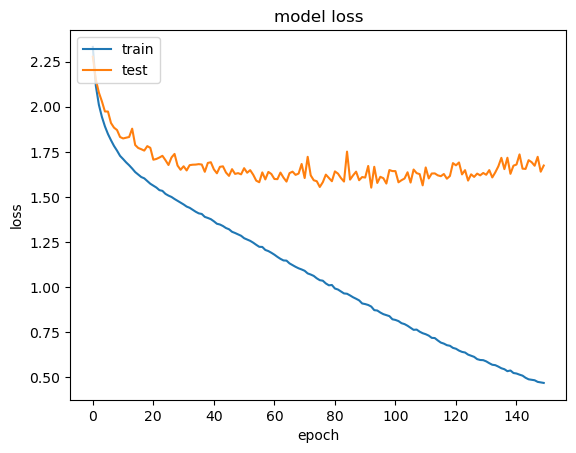

In [13]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Notice that I've increased the number of epochs to 150 in this notebook. Now if you recall in Part 3, we set to 100 epochs and the logloss plot shows that it has reached full potential at a logloss of about 1.6 after about 50 epochs, and further epochs doesn't really make it more accuracy anymore. With data augmentation however, it seems to indicate that it hasn't quite plateau yet and could still get better. 

And so that's why i've increased the number of epochs so it can achieve its full potential. Originally when I set to 100 epochs, the plot indicated it hasn't plateau. So i reran at 150 and you can see cleary now that around 100 epochs diminishing returns sets in. I'm going to keep the final model at 150 instead of 100. 

<a id="serialise"></a>
## 4. Model serialisation
So we serialise the model...

In [14]:
# Save model and weights
model_name = 'Emotion_Model_aug.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open("model_json_aug.json", "w") as json_file:
    json_file.write(model_json)

Save model and weights at /Users/chaunguyen/Desktop/Speech_Emotion_Recognition/saved_models/Emotion_Model_aug.h5 


<a id="validation"></a>
## 5. Model validation
So if you recall in part 3, the model accuracy at 100 epochs was at 43.80%... 

In [16]:
# loading json and model architecture 
json_file = open('model_json_aug.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model_aug.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


2022-10-03 21:43:55.419159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


accuracy: 48.62%


We now have 48.41%. Yes it is at 150 epochs but even at 100 it would yeild rougly the same results as per illustrated on the plot above. So now lets run it through the test set.

In [17]:
preds = loaded_model.predict(X_test, 
                         batch_size=16, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

 32/571 [>.............................] - ETA: 1s

2022-10-03 21:44:23.278732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


571/571 [==============================] - 2s 3ms/step


array([ 1,  5,  1, ..., 11, 10,  1])

Then append the labels to it before we run the accuracy measure...

In [18]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[170:180]

,actualvalues,predictedvalues
170,female_surprise,female_surprise
171,female_fear,female_fear
172,female_neutral,female_neutral
173,female_surprise,female_surprise
174,male_surprise,male_surprise
175,male_disgust,male_neutral
176,female_fear,female_fear
177,female_disgust,female_neutral
178,male_disgust,male_neutral
179,male_fear,female_disgust


Lets write the predictions out into a file for re-use

In [19]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,1068
female_disgust,1447
female_fear,786
female_happy,1040
female_neutral,857
female_sad,929
female_surprise,374
male_angry,439
male_disgust,265


So how well have we done? Have we made a significant improvement? 

#### Emotion by gender accuracy  
So lets visualise how well we have done for the Emotion by Gender model

0.48618723964042976


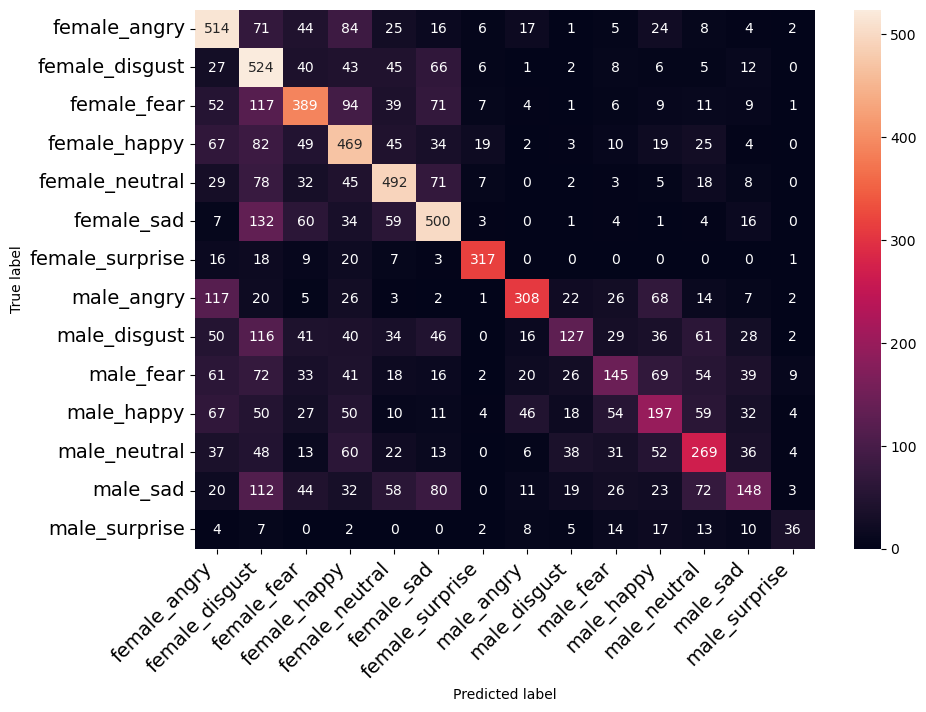

In [20]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [21]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.48      0.63      0.54       821
 female_disgust       0.36      0.67      0.47       785
    female_fear       0.49      0.48      0.49       810
   female_happy       0.45      0.57      0.50       828
 female_neutral       0.57      0.62      0.60       790
     female_sad       0.54      0.61      0.57       821
female_surprise       0.85      0.81      0.83       391
     male_angry       0.70      0.50      0.58       621
   male_disgust       0.48      0.20      0.29       626
      male_fear       0.40      0.24      0.30       605
     male_happy       0.37      0.31      0.34       629
   male_neutral       0.44      0.43      0.43       629
       male_sad       0.42      0.23      0.30       648
  male_surprise       0.56      0.31      0.40       118

       accuracy                           0.49      9122
      macro avg       0.51      0.47      0.47      9122
   weighted avg       0.49   

The accuracy for the gender by emotions in Part 3 is 43%, and we got 48%, which is great. A small but not unexpected uplift given we only introduce 2 augmentation methods. 

---------------
#### Gender accuracy result 
if you notice, that the gender classification is more accurate. So lets group them up and measure the accuracy again?

0.804976978732734


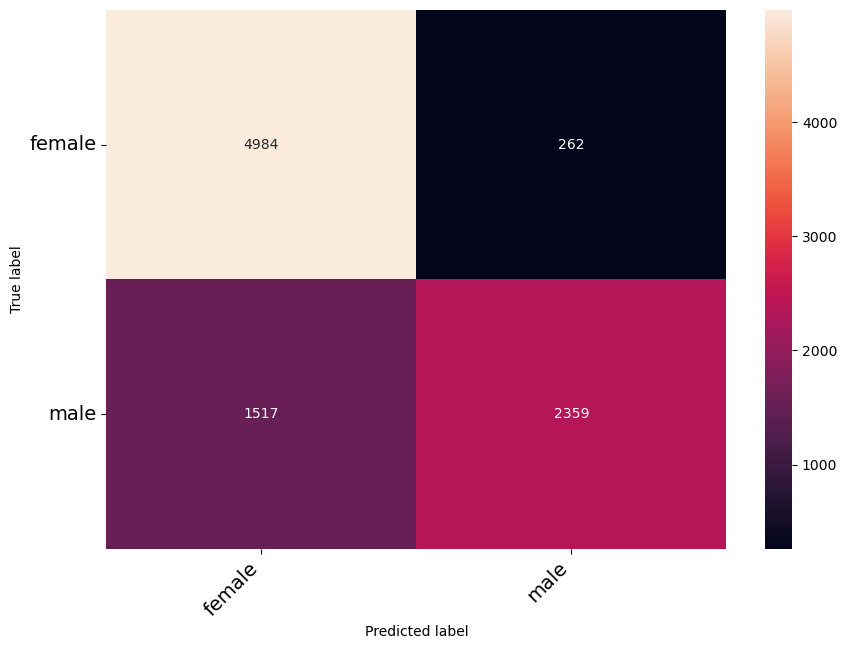

In [22]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [23]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.77      0.95      0.85      5246
        male       0.90      0.61      0.73      3876

    accuracy                           0.80      9122
   macro avg       0.83      0.78      0.79      9122
weighted avg       0.82      0.80      0.80      9122



With data augmentation we get 80.8% compared to 80.4% without augmentation. So not much difference when differentiating by gender. 

#### Emotion accuracy
We'll now ignore the gender part and just super group them into the 7 core emotions. Lets see what we get...

0.5408901556676168


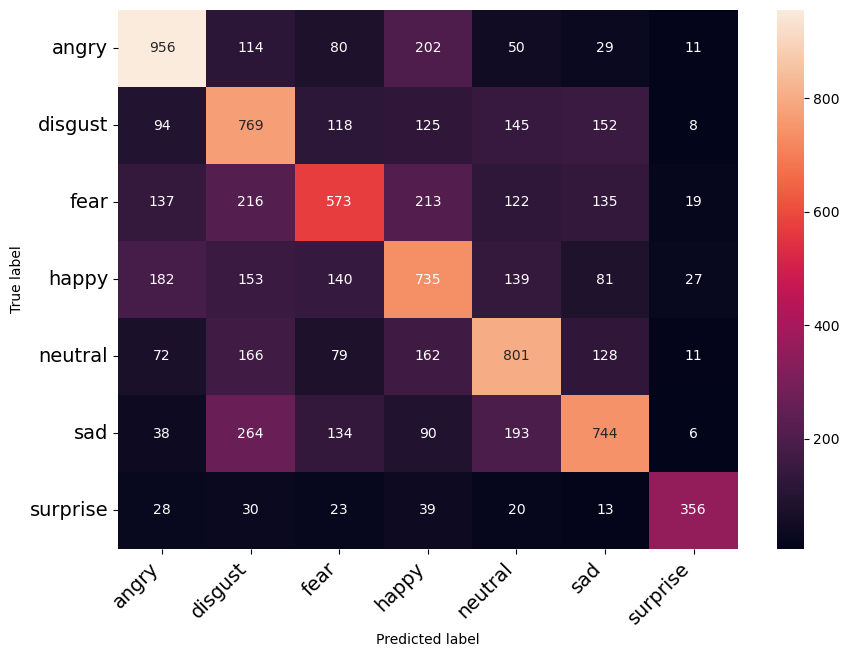

In [24]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [25]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.63      0.66      0.65      1442
     disgust       0.45      0.55      0.49      1411
        fear       0.50      0.40      0.45      1415
       happy       0.47      0.50      0.49      1457
     neutral       0.54      0.56      0.55      1419
         sad       0.58      0.51      0.54      1469
    surprise       0.81      0.70      0.75       509

    accuracy                           0.54      9122
   macro avg       0.57      0.56      0.56      9122
weighted avg       0.55      0.54      0.54      9122



54% compared to 49% without data augmentation. 

<a id="final"></a>
## 6. Final thoughts 
So its quite clear that data augmentation does help improve the accuracy albeit slightly. Note that we only introduced 2 augmentation methods. Perhaps if we include more it may make it more accurate. But there comes to a point where we have to consider the trade off between speed and accuracy. 

Next section we're going to look at implementing more advance modelling techniques. And of course, we'll be bringing forward this 2 augmentation methods that we just do today